In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import copy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

## Import danych, uzupełnienie brakujących wartości

In [2]:
original_values = pd.read_csv("dataset/train.csv", parse_dates=["datetime"])
original_values.index = original_values["datetime"]
predicted_missing_values = pd.read_csv("dataset/test_predicted.csv", parse_dates=["datetime"])
predicted_missing_values.index = predicted_missing_values["datetime"]

In [3]:
data = pd.concat([original_values[["count"]], predicted_missing_values[["count"]]])
data_analysis = pd.DataFrame(copy.deepcopy(data))
data_analysis["datetime"] = data_analysis.index
data_analysis["year"], data_analysis["month"]  = data_analysis["datetime"].dt.year, data_analysis["datetime"].dt.month
data_analysis["day"], data_analysis["hour"] = data_analysis["datetime"].dt.day, data_analysis["datetime"].dt.hour

In [4]:
## uzupełnienie brakująych wartości średnią z miesiąca
mean_val_y_m_h = data_analysis.groupby(["year", "month", "hour"]).mean()
start_date = datetime.datetime(2011, 1, 1, 0)
end_date = datetime.datetime(2013, 1, 1, 0)
delta = datetime.timedelta(hours=1)
while start_date < end_date:
    current_date = pd.Timestamp(start_date)
    if current_date not in data.index:
        year, month, hour = current_date.year, current_date.month, current_date.hour
        value_fill = mean_val_y_m_h.loc[year, month, hour]["count"]
        data.loc[current_date, "count"] = value_fill
    start_date += delta

In [5]:
data.sort_index(inplace=True)

## Sprawdzenie trendu oraz sezonowości

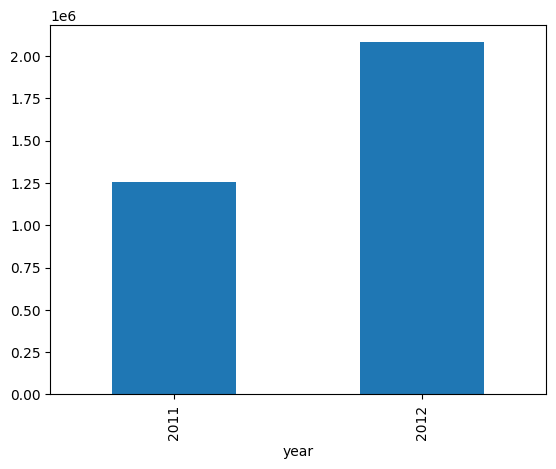

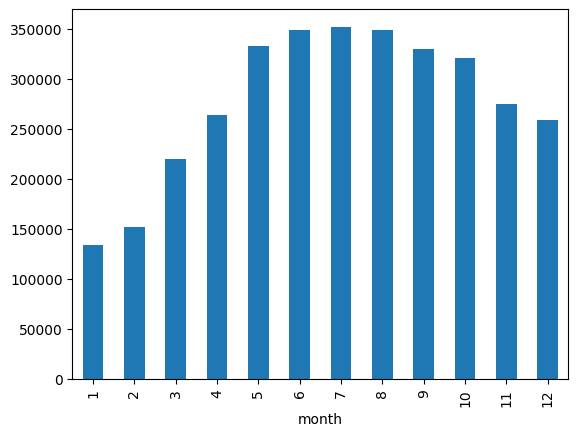

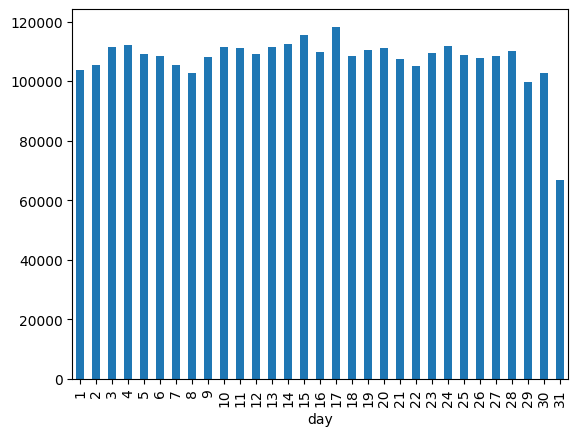

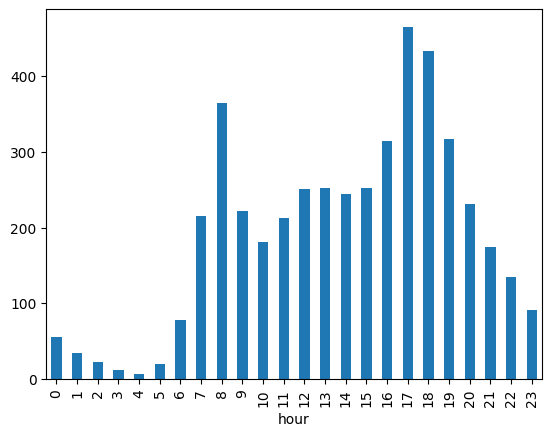

In [6]:
data_analysis.groupby("year").sum()["count"].plot.bar()
plt.show()
data_analysis.groupby("month").sum()["count"].plot.bar()
plt.show()
data_analysis.groupby("day").sum()["count"].plot.bar()
plt.show()
data_analysis.groupby("hour").mean()["count"].plot.bar()
plt.show()

Mamy do czynienia z trendem rocznym, sezonowścią, w lekkim stopniu z zależnością od dni oraz godzinowością. Dla pewności sprawdźmy jeszcze korelację  naszych danych - ACF i PACF ploty:

## Autokorelacja addytywna i multiplikatywna szeregu

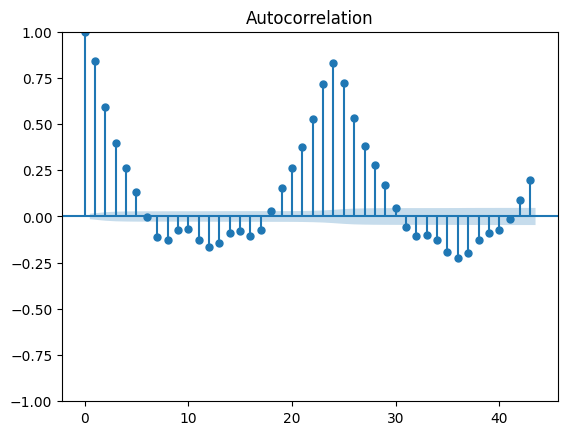

C:\Users\sitek\Desktop\homework\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


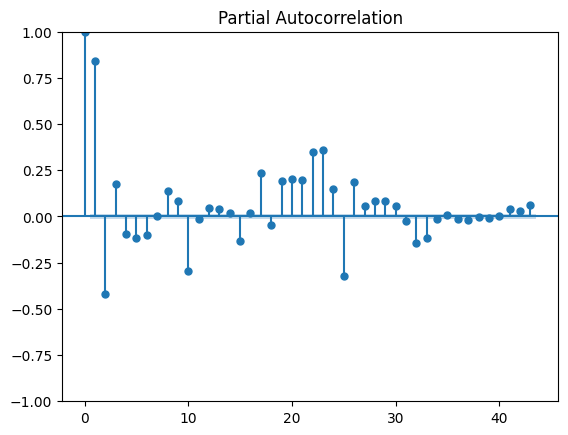

In [7]:
plot_acf(data)
plt.show()
plot_pacf(data)
plt.show()

## Próba dekompozycji szeregu

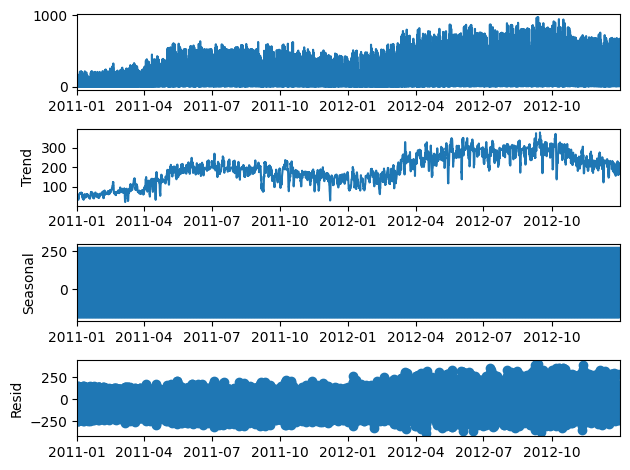

In [8]:
seasonal_dec = seasonal_decompose(data)
seasonal_dec.plot()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

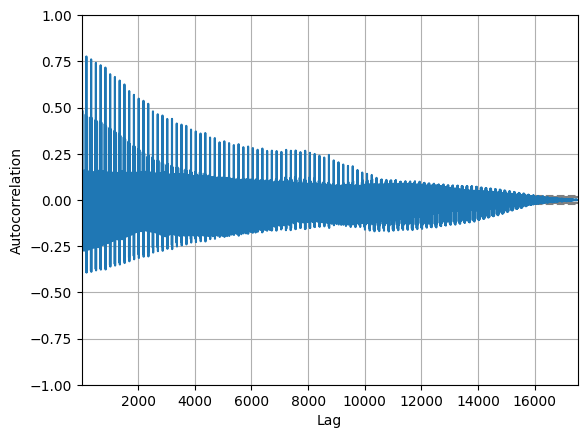

In [9]:
pd.plotting.autocorrelation_plot(seasonal_dec.resid.dropna())

Dekompozycja szeregu nie powiodła się. Dzieje się tak z uwagi na "godzinowość". Rezydua są skorelowane. Do takich danych nie użyjemu modelów ARIMA, lepsza będzie funkcja *ExponentialSmoothing*
## Predykcje przy użyciu *ExponentialSmoothing*

In [15]:
smooth = ExponentialSmoothing(data, trend="additive", seasonal="additive", seasonal_periods=24, freq='h', use_boxcox=True)
smooth.fit()

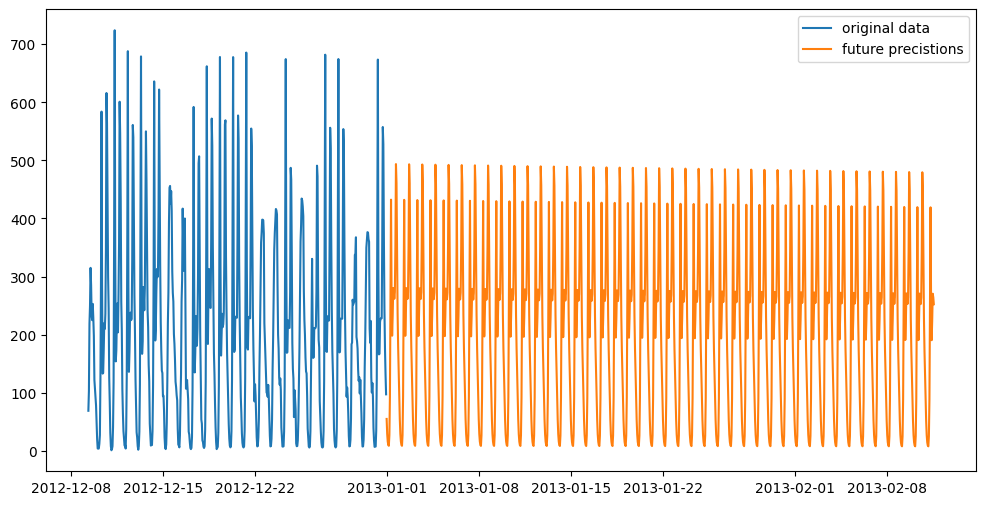

In [18]:
pred_hours_ahead = 1000
future_period = [data.index[-1] + datetime.timedelta(hours=i) for i in range(1, pred_hours_ahead)]

start = future_period[0]
end = future_period[-1]

plt.figure(figsize=(12, 6))
plt.plot(data.index[17000:], data.iloc[17000:]["count"], label="original data")
plt.plot(future_period, smooth.predict(smooth.params, start, end), label="future precistions")
plt.legend()
plt.show()

**Wnioski**: Po graficznej ewaluacji działania modelu, można stwierdzić, że jest on raczej średni.